# Preparation

In [1]:
! pip install faker

In [2]:
! pip install sklearn

In [3]:
! pip install shapely

In [4]:
from pyforest import *
from pprint import pprint

# Generate sample json files

In [5]:
def generate_value_pair(number):
    '''
    generate the number of lat long pairs stored in a list
    
    arguments:
    number(int): define the number of value pairs needed
    
    return a list containing the value pairs
    '''
    import random
    
    l = []
    for i in range(number):
        l.append([random.random()+1, random.random()+103])
    return l

In [6]:
import json
from faker import Faker
import random
from random import randint
fake = Faker('en_US')


NUM_OF_ASSETS = 100
my_dict = {
    'assets': {
        'houses': {
            'private housing': {
                'name': 'private housing',
                'num': NUM_OF_ASSETS,
                'pos': generate_value_pair(NUM_OF_ASSETS)
            }
        }
    }
}
pprint(my_dict)
l_points = generate_value_pair(NUM_OF_ASSETS)

{'assets': {'houses': {'private housing': {'name': 'private housing',
                                           'num': 100,
                                           'pos': [[1.472427376569076,
                                                    103.56474623601369],
                                                   [1.1715684670109567,
                                                    103.09036176963865],
                                                   [1.2349595844235202,
                                                    103.26867311437577],
                                                   [1.6908157378914357,
                                                    103.12735571997771],
                                                   [1.3687052575389582,
                                                    103.848464928999],
                                                   [1.5820075666315583,
                                                    103.49419309404165],
        

# Load points as DataFrame

In [7]:
l_points

[[1.464492243485969, 103.11099081998191],
 [1.8936412878855675, 103.99052861125134],
 [1.0109434698694266, 103.13761693081503],
 [1.9993714279549408, 103.48668790448545],
 [1.9281610428116016, 103.62541473973425],
 [1.1568768514072367, 103.99161390852902],
 [1.1284101446860721, 103.88152397787564],
 [1.9409150294253334, 103.92751784826943],
 [1.4166985039311961, 103.84345781762381],
 [1.6338141077377544, 103.36477561911049],
 [1.006990647080519, 103.49804840293544],
 [1.0639553946899039, 103.82173908637607],
 [1.8943090891451033, 103.44057624091354],
 [1.873972594513792, 103.83512092174239],
 [1.224492516237956, 103.11973649870858],
 [1.8685510682776612, 103.96018933740837],
 [1.8684799948972723, 103.6199101055929],
 [1.5889109265156138, 103.05572176682259],
 [1.896859362161318, 103.33929235146287],
 [1.9484990538184155, 103.65541905173454],
 [1.5661122521636885, 103.60788848394184],
 [1.154627869298837, 103.46989941036209],
 [1.6425895135128288, 103.88943962684917],
 [1.11822277719566

In [8]:
data = pd.DataFrame.from_dict(my_dict)

In [9]:
df = pd.DataFrame(l_points)

In [10]:
df = df.rename({0: 'Lat', 1: 'Long'}, axis=1)

# Cluster points by DBSCAN

## Cluster points using DBSCAN

In [11]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [12]:
# load lat & long into variable X
X = df[['Lat', 'Long']].values

In [13]:
# run DBSCAN
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon,
            min_samples=1,
            algorithm='ball_tree',
            metric='haversine').fit(np.radians(X))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([X[cluster_labels == n] for n in range(num_clusters)])
print('Number of DBSCAN clusters: {}'.format(num_clusters))

Number of DBSCAN clusters: 99


In [14]:
# find a cluster’s center-most point
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [15]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [16]:
rs = rep_points.apply(lambda row: df[(df['Lat']==row['lat']) & (df['Long']==row['lon'])].iloc[0], axis=1)

## Plot points on map

In [17]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['Long'], rs['Lat'], c='#ff5c5c', edgecolor='None', alpha=0.7, s=120)
df = ax.scatter(df['Long'], df['Lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df, rs_scatter], ['Full set', 'Cluster Set'], loc='best')
plt.show()

# Cluster points by K-means

In [18]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

In [19]:
# run K-means clustering
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

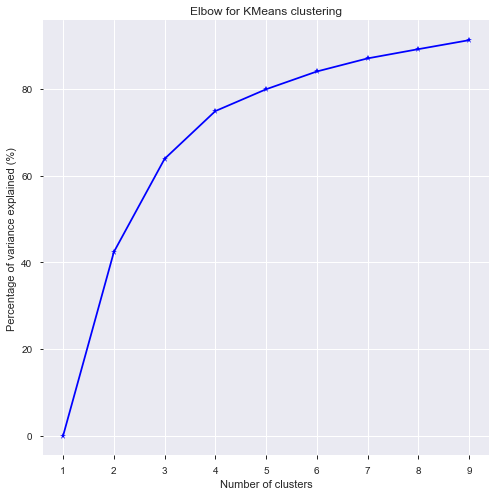

In [20]:
# find elbow points
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

## Find optimal K

In [51]:
def find_optimal_K(X):
    from sklearn.metrics import silhouette_score

    sil = []
    KMAX = 10

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, KMAX+1):
        kmeans = KMeans(n_clusters = k).fit(X)
        labels = kmeans.labels_
        sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    print(sil)
    
    sil_max = max(sil)
    print(sil_max)
    
    len_sil = len(sil)
    for i in range(len_sil):
        rounded_sil = round(sil[i], 1)
        rounded_sil_max = round(sil_max, 1)
        if (rounded_sil == rounded_sil_max) and (sil[i] > sil[i+1]):
            return i+2

In [52]:
find_optimal_K(X)

[0.39007955608165706, 0.4124423415230782, 0.384931609187915, 0.3818890979583795, 0.3968143144342921, 0.4178544115670198, 0.4169458472065817, 0.433526794184248, 0.44026962054905994]
0.44026962054905994


3

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

print(kmeans.labels_)
print(kmeans.cluster_centers_)

[2 3 2 0 3 1 1 3 1 0 2 1 0 3 2 3 3 0 0 3 3 2 3 1 0 0 2 0 0 1 2 2 0 1 0 3 3
 0 3 1 0 1 2 2 2 3 1 0 1 1 1 2 1 1 0 0 2 2 3 3 0 1 3 2 1 2 3 2 2 1 0 0 3 0
 1 1 1 0 0 1 0 0 0 1 2 3 0 3 0 3 1 2 0 1 3 0 0 2 2 1]
[[  1.82157677 103.28988478]
 [  1.29904466 103.7949939 ]
 [  1.24885105 103.2618496 ]
 [  1.79049842 103.73622194]]
